In [1]:
import numpy as np
from copy import deepcopy as copy
import tqdm
import numba
%config Completer.use_jedi = False

In [7]:

# %%
@numba.jit(nopython=True)
def relu(x):
    return max(x, 0)

@numba.jit(nopython=True)
def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

@numba.jit(nopython=True)
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

class NodeGene:
    def __init__(self, id, type, h=0, bias=np.random.uniform(-1, 1)):
        self.h = h
        self.type = type
        self.id = id
        self.bias = bias


class ConnectionGene:
    def __init__(self, inputNode, outputNode, weight, innovation, enabled=True):
        self.enabled = enabled
        self.innovation = innovation
        self.weight = weight
        self.outputNode = outputNode
        self.inputNode = inputNode


class Specimen:
    # generating Phenotype from Genotype

    def __init__(self, input_, output, protection = 3):
        self.id_of_next = output + input_

        inputs = [NodeGene(i, 'input') for i in range(input_)]
        outputs = [NodeGene(i + len(inputs), 'output', h=1) for i in range(output)]

        self.nodes = inputs + outputs
        self.protection = protection
        self.connections = []
        innovation = 0
        for i in range(input_):
            for j in range(input_, input_ + output):
                self.connections.append(ConnectionGene(i, j, np.random.normal(0, 1), innovation))
                innovation += 1

    def create_new(self):
        new_specimen = copy(self)
        new_specimen.protection = 3
        return new_specimen

    def forward(self, input_):

        order = [node.h for node in self.nodes]
        output = np.array([None]* (len(self.nodes) - len(input_)))
        order = np.argsort(order)
        values = [0] * len(self.nodes)
        values = np.array(values).astype('float32')
        # now we are sending the signal
        for i, node in enumerate([self.nodes[i] for i in order]):
            if node.h == 0:
                values[node.id] = input_[node.id]
                for connection in self.connections:
                    if connection.inputNode == node.id:
                        values[connection.outputNode] += relu(values[node.id] * connection.weight + node.bias)

            elif node.h > 0 and node.h < 1:

                for connection in self.connections:
                    values[connection.outputNode] += relu(values[node.id] * connection.weight + node.bias)

            elif node.h == 1:
                # this is output neuron
                output[node.id - len(input_)] = values[node.id]

        return output

    def return_with_mutated_weight(self, threshold=0.8):
        new = copy(self)
        for connection in new.connections:
            if np.random.uniform(0, 1) < threshold:
                connection.weight *= np.random.uniform(-2.5, 2.5)
            else:
                connection.weight = np.random.uniform(-1, 1)

        return new

    def return_with_mutated_bias(self, threshold=0.8):
        new = copy(self)
        for node in new.nodes:
            if np.random.uniform(0, 1) < threshold:
                node.bias *= np.random.uniform(-2.5, 2.5)
            else:
                node.bias = np.random.uniform(-1, 1)
        return new

    def accuracy(self, x, y):

        res = []
        for inp in x:
            res.append(np.argmax(softmax(self.forward(inp).astype('float32'))))

        return ((res == y) * 1).mean()

    def mae(self, x, y):
        res = []
        for inp in x:
            res.append(self.forward(inp))

        return np.abs(x - y).mean()


class NEAT:

    def __init__(self, population_number, input_, output):
        self.population_number = population_number
        self.input = input_
        self.output = output
        self.innovation = input_ * output
        self.connection_innovations = []
        self.gen_mean = []

    def start(self):
        # initialize the population
        self.population = [Specimen(self.input, self.output) for i in range(self.population_number)]

    def calculate_innovation(self, connection_innovation):

        for nodes in self.connection_innovations:
            if nodes[0] == connection_innovation:
                k = nodes[1]
                return [k, k + 1]

        # if there was no innovation like this before, than:
        self.connection_innovations.append([connection_innovation, self.innovation])
        p = self.innovation
        self.innovation += 2

        return [p, p + 1]

    def add_connection(self, network):
        new_network = copy(network)
        a, b = np.random.choice(network.nodes, 2, replace=False)
        does_exist = False

        # first search for connection in genes
        for connection in new_network.connections:
            if a.id == connection.inputNode and b.id == connection.outputNode:
                does_exist = True
        if a.type != b.type:
            if not does_exist:
                if a.h < b.h:
                    new_network.connections.append(
                        ConnectionGene(a.id, b.id, np.random.uniform(-1, 1), self.innovation))
                else:
                    new_network.connections.append(
                        ConnectionGene(b.id, a.id, np.random.uniform(-1, 1), self.innovation))
                self.innovation += 1
        return new_network

    @staticmethod
    def find_connection_by_innovation(specimen, innovation):
        for connection in specimen.connections:
            if connection.innovation == innovation:
                return connection

    def cross(self, a, b):

        child = Specimen(0,0)
        if len(a.nodes) > len(b.nodes):
            child.nodes = a.nodes
        else :
            child.nodes = b.nodes

        a_innovations = [x.innovation for x in a.connections]
        b_innovations = [x.innovation for x in b.connections]

        for innovation_number in range(max(a_innovations) + max(b_innovations) + 1):
            if innovation_number in a_innovations:
                if innovation_number in b_innovations:
                    if np.random.uniform(0,1) > 0.5:
                        new_connection = copy(self.find_connection_by_innovation(a, innovation_number))
                    else :
                        new_connection = copy(self.find_connection_by_innovation(b, innovation_number))

                    child.connections.append(new_connection)
                else:
                    new_connection = copy(self.find_connection_by_innovation(a, innovation_number))
                    child.connections.append(new_connection)
            else:
                if innovation_number in b_innovations:
                    new_connection = copy(self.find_connection_by_innovation(b, innovation_number))
                    child.connections.append(new_connection)

        return child

    def add_node(self, network):
        new_network = copy(network)
        a = new_network.connections[np.random.choice(len(new_network.connections), 1)[0]]
        if a.enabled:

            a.enabled = False
            higher_node_id = new_network.id_of_next
            new_network.id_of_next += 1

            height_input = new_network.nodes[a.inputNode].h
            height_output = new_network.nodes[a.outputNode].h
            h = np.random.uniform(0.7 * height_input + 0.3 * height_output, 0.3 * height_input + 0.7 * height_output)
            new_network.nodes.append(NodeGene(higher_node_id, 'hidden', h=h))
            innovation = self.calculate_innovation(a.innovation)

            new_network.connections.append(
                ConnectionGene(a.inputNode, higher_node_id, np.random.uniform(-1, 1), innovation[0]))
            new_network.connections.append(
                ConnectionGene(higher_node_id, a.outputNode, np.random.uniform(-1, 1), innovation[1]))
            return new_network
        else:
            return network

    def start_evolution(self, x, y, epochs=50, to_mutate=0.7, measure='acc'):
        best_specimen = None
        for i in tqdm.trange(epochs):
            nodes_to_mutate = np.random.choice(self.population_number, int(np.ceil(self.population_number * to_mutate)))
            nodes_to_mutate = [self.population[i].create_new() for i in nodes_to_mutate]
            spec_with_mutated_node = [self.add_node(specimen) for specimen in nodes_to_mutate]
            connection_to_mutate = np.random.choice(self.population_number, int(np.ceil(self.population_number * to_mutate)))
            connection_to_mutate = [self.population[i].create_new() for i in connection_to_mutate]
            spec_with_mutated_connection = [self.add_connection(specimen) for specimen in connection_to_mutate]
            weight_to_mutate = np.random.choice(self.population_number, int(np.ceil(self.population_number * to_mutate)))
            weight_to_mutate = [self.population[i].create_new() for i in weight_to_mutate]
            spec_with_mutated_weight = [specimen.return_with_mutated_weight() for specimen in weight_to_mutate]
            bias_to_mutate = np.random.choice(self.population_number, int(np.ceil(self.population_number * to_mutate)))
            bias_to_mutate = [self.population[i].create_new() for i in bias_to_mutate]
            spec_with_mutated_bias = [specimen.return_with_mutated_bias() for specimen in bias_to_mutate]

            to_cross = np.random.choice(self.population_number, int(np.ceil(self.population_number * to_mutate)), replace=False)
            spec_crossed = []
            for j in range(0, len(to_cross)-1, 2):
                spec_crossed.append(self.cross(self.population[to_cross[j]], self.population[to_cross[j + 1]]))

            new_population = self.population + spec_with_mutated_node + spec_with_mutated_connection + spec_with_mutated_weight + spec_with_mutated_bias + spec_crossed

            metrics_for_new_population = [specimen.accuracy(x, y) for specimen in new_population]

            best_ = np.argsort(metrics_for_new_population)
            best = best_[-self.population_number:]

            for spec in new_population:
                if spec.protection > 0:
                    self.population.append(spec)

            for i, spec in enumerate(self.population):
                spec.protection -= 1
                self.population[i] = spec

            self.population = list(np.array(new_population)[best])
            self.gen_mean.append(np.mean([specimen.accuracy(x, y) for specimen in self.population]))
            print(f'Population mean: {self.gen_mean[-1]}Population best: {np.max(metrics_for_new_population)}', end='\r')

        metrics_for_new_population = [specimen.accuracy() for specimen in self.population]
        best = np.argsort(metrics_for_new_population)
        self.best = self.population[best[-1]]


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
train = pd.read_csv("../data/rings3-regular-training.csv")
test = pd.read_csv("../data/rings3-regular-test.csv")

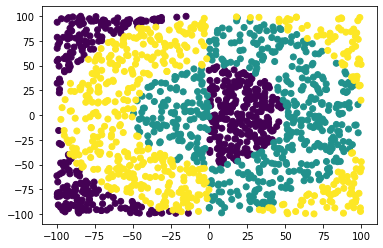

In [10]:
plt.scatter(train['x'], train['y'], c=train['c'])
plt.show()

In [11]:
train_x = np.asarray(train.iloc[:,0:2])
train_y = np.asarray(train.iloc[:,2])

x = np.asarray(train_x)
x = (x - np.mean(x, axis = 0))/np.std(x, axis = 0)
y = np.asarray(train_y)

In [ ]:
neat = NEAT(100, 2, 3)
neat.start()
neat.start_evolution(x, y, epochs=30)

  3%|██▊                                                                                | 1/30 [00:47<22:45, 47.07s/it]